# Implement of a Gaussian curvature, mean curvature

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

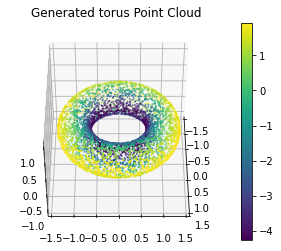

In [2]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    K = np.cos(phi)/(r * (R + r * np.cos(phi))) 
    H = (R + 2* r * np.cos(phi))/ (2 * r * (R + r * np.cos(phi)))
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c)), K, H

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a torus point cloud with 1000 points and radius 1
torus, torus_centers, torus_K, torus_H = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

torus += np.random.normal(0, 0.0, torus.shape)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=1, c = torus_K)
#ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=10, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated torus Point Cloud")
plt.colorbar(scatter)
ax.view_init(45, 0)
plt.show()


In [4]:
def epsilon_and_tau(point_cloud, query):
    ratio_all = []
    nbrs = NearestNeighbors(n_neighbors=2500, algorithm='ball_tree').fit(point_cloud)
    for i in range(1, 150):
        epsilon_PCA = 0.01 * i 
        ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

        pca_nbrs = point_cloud[ep_idx[0]]
        Xi = pca_nbrs - query
        Di = np.diag(np.sqrt(np.exp(-1*np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
        Bi = Xi.T @ Di
    
        U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
        if len(S)>= 2: 
            ratio = (S[0]+ S[1])/sum(S)
        else:
            ratio = 1.0
        ratio_all.append(ratio)
    tau = 0.01 * np.argmin(np.array(ratio_all) - min(ratio_all))
    eps_PCA = 0.01 * np.argmin(np.abs(np.array(ratio_all) - 0.85))
    return eps_PCA, tau
def Gaussian_Curvature_High(point_cloud, query_point,  intrin_dim = 2, epsilon_PCA = 0.1, tau_radius = 0.4, 
                            prpl_percent = 0.5, use_cross = True, use_heuristic = False):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.2 * point_cloud.shape[0])
    
    if use_heuristic: 
        epsilon_PCA, tau_radius = epsilon_and_tau(point_cloud, query_point)
    else:
        pass
        

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(query_point, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(query_point, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - query_point
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT
    
    tau_nbrs_new = tau_nbrs[1:]
    tau_dist_new = tau_dist[0][1:]
    
    cur = []
    for i in range(intrin_dim):
        for j in range(i+1, intrin_dim):
            for k in range(intrin_dim + 1):
                if k != i and k != j:
                    O2 = O[k]
                    ti = tau_nbrs_new - query_point[0]
                    norms = np.square(ti).sum(axis=1)
                    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    
            max_min_num = int(prpl_percent * len(tau_nbrs_new))
            max_indices = np.argsort(tensor_all)[-max_min_num: ]
            max_cur = tensor_all[max_indices]
    
            min_indices = np.argsort(tensor_all)[:max_min_num]
            min_cur = tensor_all[min_indices]
    
            max_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[max_indices]) ** 2 / np.sqrt(tau_radius)))
            min_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[min_indices]) ** 2 / np.sqrt(tau_radius)))
    
            principal_cur1 = sum(max_cur_weight * max_cur)/sum(max_cur_weight)
            principal_cur2 = sum(min_cur_weight * min_cur)/sum(min_cur_weight)
            cur.append(principal_cur1 * principal_cur2)
      
    return sum(cur)
    

# Gaussian curvature 

## No heuristic

In [19]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = Gaussian_Curvature(torus, torus[i].reshape(1, -1), 
                           epsilon_PCA =0.2, tau_radius = 0.8, prpl_percent = 0.3)
    curvature.append(b)

100%|██████████| 5000/5000 [00:17<00:00, 287.02it/s]


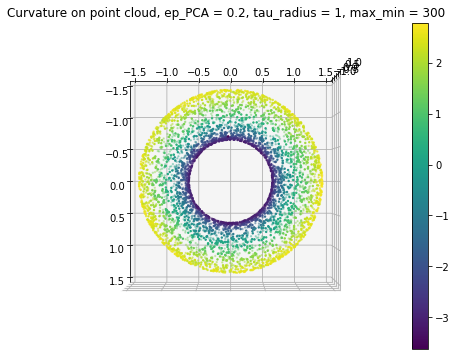

In [20]:
v = np.array(curvature).T
# Visualize the point cloud

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 300")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [21]:
corr, _ = pearsonr(torus_K , v)
corr

0.997106466079824

In [36]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(torus_K[:100], v[:100]))
rmse

0.8138667671159985

## Use heuristic 

In [31]:
use_heuristic = True

num_eval = int(len(torus)/50)
curvature = []
for i in tqdm(range(num_eval)):
    b = Gaussian_Curvature(torus, torus[i].reshape(1, -1), 
                           epsilon_PCA =0.2, tau_radius = 0.8, prpl_percent = 0.3, use_heuristic = use_heuristic)
    curvature.append(b)

100%|██████████| 100/100 [06:52<00:00,  4.12s/it]


In [34]:
z = np.array(curvature).T
corr, _ = pearsonr(torus_K[:num_eval] , z)
corr

0.9914756939442408

In [38]:
rmse = np.sqrt(mean_squared_error(torus_K[:100], z[:100]))
rmse

0.6603742720319016

In [8]:
for i in range(3):
    for j in range(i+1, 3):
        for k in range(4):
            if k != i and k != j:
                print((i, j, k))

(0, 1, 2)
(0, 1, 3)
(0, 2, 1)
(0, 2, 3)
(1, 2, 0)
(1, 2, 3)
